# 3.2 线性回归的从零开始实现

In [2]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.9.0


## 3.2.1 生成数据集

In [ ]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)

tensor([ 2.7577,  3.4330,  8.1713,  2.3961, -0.6379,  2.1383,  6.7833,  2.0132,
         9.3653,  4.4066,  4.2969, -0.3601,  5.6478,  5.3655,  9.7191, -0.1294,
        -5.7190,  1.7025, -0.6097,  4.2448,  7.8122,  6.5136,  1.1655,  4.3054,
        14.5776,  3.0522,  2.3577,  5.7997,  5.7471, -1.2913,  6.0492,  4.6338,
         6.2383, -0.0327,  8.5684,  3.2515,  7.5722,  9.6169,  5.3293,  1.8643,
        -0.4696,  9.5865, -1.5743,  3.5723,  2.7724,  1.0109,  3.6886, -2.0691,
         1.0803, -6.3195,  0.1002,  3.9255, -1.3112, 12.3606,  2.6624,  6.3807,
         4.6139,  2.6426, -0.1004,  6.5360, -1.6875,  4.8798,  1.3553,  2.3143,
         7.1230,  5.8691, -1.0447,  9.5632,  2.5026,  4.7054,  9.7791,  8.7325,
         5.0741, -0.4334,  5.3778,  4.9531,  2.0627,  0.7779,  4.4722,  0.6524,
         5.4831,  1.7924,  0.3540,  4.0996, 11.6432,  4.5887,  6.4807, -3.0017,
         2.8789,  4.8638,  3.1542,  4.4634, -0.3897,  7.1227,  8.3138, -0.7871,
         4.7770,  6.7015, -2.2282,  3.92

In [14]:
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# labels = torch.matmul(features, torch.Tensor(true_w))+true_b

In [15]:
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [16]:
print(features[0], labels[0])

tensor([1.0716, 1.0546]) tensor(2.7570)


<ipython-input-17-929a5980f0a5>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


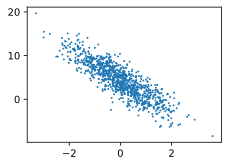

In [17]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 3.2.2 读取数据

In [33]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [34]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.1022,  1.0737],
        [ 0.3964, -1.3121],
        [-1.4727, -0.3207],
        [ 0.1297, -0.1754],
        [-0.4646, -0.4545],
        [-0.1122, -0.0282],
        [ 0.6612,  0.3393],
        [-0.4644, -1.2032],
        [-0.4054, -1.2681],
        [ 0.4082,  1.2852]]) 
 tensor([-1.6421,  9.4621,  2.3349,  5.0535,  4.8325,  4.0790,  4.3824,  7.3501,
         7.6964,  0.6545])


## 3.2.3 初始化模型参数

In [51]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [52]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

In [53]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [54]:
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

In [55]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

In [56]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {l.mean().item()}')

epoch 1, loss 0.42240360379219055
epoch 2, loss 0.001187735004350543
epoch 3, loss 0.00027628600946627557
epoch 4, loss 0.00020744286302942783
epoch 5, loss 0.0003103851049672812


In [57]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0003],
        [-3.3999]], requires_grad=True)
4.2 
 tensor([4.2004], requires_grad=True)
